In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm

#from utils import *
#from methods import *

In [3]:
from models import Similitude, Similitude2
model = Similitude2(scale=146.2,ncells=100)

In [4]:
if False:
    # Overwrite Initial Phase Placements
    start_phases = torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)
    #start_phases = torch.cat([torch.normal(torch.zeros((model.ncells,2)),0.01),torch.normal(torch.zeros((model.ncells,2))+0.2,0.01)])
    
    model.set_phases(start_phases)
    
# use same start phases for each Similitude scale
start_phases = model.phases.clone().detach()

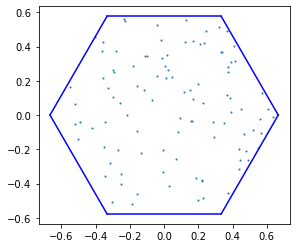

In [5]:
fig,ax=model.unit_cell.plot()
ax.scatter(*model.phases.detach().T,s=1)

In [6]:
# Train model
nsamples_space = 2**10
def train_similitude(model,nepochs=2000):
    loss_history = []
    phases_history = [model.phases.clone().detach().numpy()]
    mt_stats_history = {'min': [], 'max': [], 'mean': [], 'std': []}
    for epoch in tqdm.trange(nepochs):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=torch.float32)
        loss = model.train_step(rs)
        mt = model.metric_tensor(rs).numpy()
        mt_stats_history['min'] = np.min(mt,axis=0)
        mt_stats_history['max'] = np.max(mt,axis=0)
        mt_stats_history['mean'] = np.mean(mt,axis=0)
        mt_stats_history['std'] = np.std(mt,axis=0)
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
    return loss_history, phases_history, mt_stats_history

In [7]:
# line search over scales
similitude_scales = np.linspace(0,200,10)
loss_histories,phases_histories,mt_stats_histories=[],[],[]
for similitude_scale in similitude_scales:
    # set similitude scale and reset phases
    model.scale = similitude_scale
    model.set_phases(start_phases)
    # train
    loss_history, phases_history, mt_stats_history = train_similitude(model)
    loss_histories.append(loss_history)
    phases_histories.append(phases_history)
    mt_stats_histories.append(mt_stats_history)
loss_histories = np.array(loss_histories)
phases_histories = np.array(phases_histories)

100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 579.21it/s]


(7, 1254)


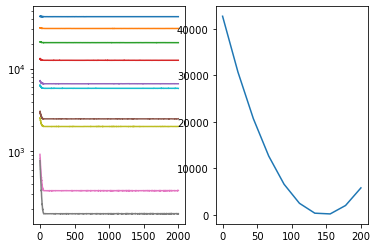

In [12]:
loss_histories = np.array(loss_histories)
idx_min = np.unravel_index(np.argmin(loss_histories, axis=None), loss_histories.shape)
print(idx_min)
fig,axs = plt.subplots(ncols=2)
#axs[0].plot(loss_histories[idx_min[0]])
axs[0].plot(loss_histories.T)
axs[0].semilogy()
axs[1].plot(similitude_scales,np.min(loss_histories,axis=-1))

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

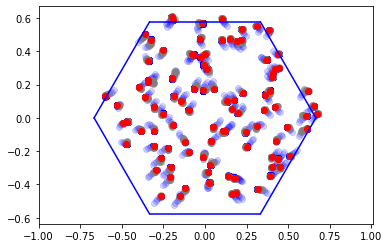

In [9]:
N = len(phases_history)
fig, ax = plt.subplots()
[ax.scatter(*phases_histories[idx_min[0],i].T, c='blue', alpha=(i+0.2*N)/(1.2*N)) for i in range(0,N,10)]
ax.scatter(*phases_histories[:,-1].T, c='grey',alpha=0.5)
ax.scatter(*phases_histories[idx_min[0],-1].T, c='red')
ax.axis('equal')
model.unit_cell.plot(fig,ax)
#model.unit_cell.plot(fig,ax,center=np.mean(phases_history[-1],axis=0))

In [15]:
torch.nn.Parameter(torch.tensor(2,dtype=torch.float32))

Parameter containing:
tensor(2., requires_grad=True)

In [10]:
torch.save(model,f'./saved-models/{type(model).__name__}-{model.ncells}-dirac')

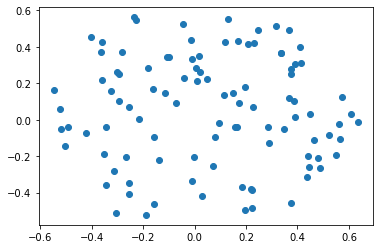

In [11]:
plt.scatter(*start_phases.T)